<a href="https://colab.research.google.com/github/amanjain252002/Implementation-of-Word2vec-and-GloVe/blob/main/skip_gram.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

from tqdm import tqdm

import nltk
nltk.download('punkt')

import tensorflow as tf
print(tf.__version__)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
2.4.1


## Data Preprocessing

In [2]:
with open("/content/Database.txt", errors = 'ignore') as f:
  Data = f.read()

In [3]:
# Raw Data
Data

'Machine learning (ML) is the study of computer algorithms that improve automatically through experience and by the use of data.[1] It is seen as a part of artificial intelligence. Machine learning algorithms build a model based on sample data, known as "training data", in order to make predictions or decisions without being explicitly programmed to do so.[2] Machine learning algorithms are used in a wide variety of applications, such as email filtering and computer vision, where it is difficult or unfeasible to develop conventional algorithms to perform the needed tasks.\nA subset of machine learning is closely related to computational statistics, which focuses on making predictions using computers; but not all machine learning is statistical learning. The study of mathematical optimization delivers methods, theory and application domains to the field of machine learning. Data mining is a related field of study, focusing on exploratory data analysis through unsupervised learning.[4][5

In [4]:
# Converts data to lowercase
Data = Data.lower()
# Removes numbers from the data
Data = re.sub(r"\b\d+\b", "", Data)
# Removes special characters from the data
Data = re.sub(r'[^A-Za-z0-9 ]+', '', Data)

In [5]:
# Processed Data
Data

'machine learning ml is the study of computer algorithms that improve automatically through experience and by the use of data it is seen as a part of artificial intelligence machine learning algorithms build a model based on sample data known as training data in order to make predictions or decisions without being explicitly programmed to do so machine learning algorithms are used in a wide variety of applications such as email filtering and computer vision where it is difficult or unfeasible to develop conventional algorithms to perform the needed tasksa subset of machine learning is closely related to computational statistics which focuses on making predictions using computers but not all machine learning is statistical learning the study of mathematical optimization delivers methods theory and application domains to the field of machine learning data mining is a related field of study focusing on exploratory data analysis through unsupervised learning in its application across busin

Tokenization is the process by which a large quantity of text is divided into smaller parts called tokens. These tokens are very useful for finding patterns and are considered as a base step for stemming and lemmatization. Tokenization also helps to substitute sensitive data elements with non-sensitive data elements.

In [6]:
words = nltk.word_tokenize(Data)

In [7]:
# Generates word_to_index and index_to_word dictionary
word_to_index = {}
index_to_word = {}
count = 0
for word in words:
  if(word not in word_to_index.keys()):
    word_to_index[word] = count
    count = count + 1
for word in word_to_index.keys():
  index_to_word[word_to_index[word]] = word

In [8]:
def get_window(words, window_size):
  Dataset = []
  for i in range(len(words)):
    for j in range(i - window_size, i + window_size + 1, 1):
      if(j < 0 or j > (len(words) - 1) or j == i):
        continue
      Dataset.append((words[i], words[j]))
  return Dataset

In [9]:
# Genrates one hot vector of word
def word_to_one_hot_vector(word, word_to_index):
  one_hot_vector = np.zeros(shape = (len(word_to_index), 1))
  one_hot_vector[word_to_index[word]][0] = 1
  return one_hot_vector

In [10]:
def get_training_example(words, window_size, word_to_index):
  X_train, y_train = [], []
  Dataset = get_window(words, window_size)
  batch_size = 100
  for i in range(1, 100000, batch_size):
    for centre_word, context_word in Dataset[i: i+batch_size-1]:
      X_train.append(word_to_one_hot_vector(centre_word, word_to_index))
      y_train.append(word_to_one_hot_vector(context_word, word_to_index))
  
  return X_train, y_train

In [11]:
X_train, y_train = get_training_example(words, 3, word_to_index)

In [12]:
X_train = np.array(X_train)
y_train = np.array(y_train)

In [13]:
print(X_train.shape)
print(y_train.shape)

(99000, 1063, 1)
(99000, 1063, 1)


In [14]:
X_train = np.array(X_train).reshape(1063, 99000)
print(X_train.shape)
y_train = np.array(y_train).reshape(1063, 99000)
print(y_train.shape)

(1063, 99000)
(1063, 99000)


## Modeling

In [15]:
# Random normal weights intialization
def Weight_Intialization(V, n_Hidden):
  W1 = np.random.randn(n_Hidden, V)
  b1 = np.random.randn(n_Hidden, 1)
  W2 = np.random.randn(V, n_Hidden)
  b2 = np.random.randn(V, 1)
  return W1, b1, W2, b2

In [16]:
# Activation function
def relu(z):
  return np.maximum(0, z)

In [17]:
# Activation function
def softmax(z):
  ex = np.exp(z)
  return ex/np.sum(ex, axis = 0)

In [18]:
# Forward Propagation
def forward_pass(x, W1, b1, W2, b2):
  Z1 = np.dot(W1, x) + b1
  Z1 = relu(Z1)
  Z2 = np.dot(W2, Z1) + b2
  ypred = softmax(Z2)
  return Z1, Z2, ypred

In [19]:
def error_calculation(y, ypred, m):
  error = -(np.sum(np.multiply(y, np.log(ypred))))/m
  return error

In [20]:
# Back Propagation
def back_prop(W1, b1, W2, b2, Z1, Z2, y, ypred, x):
  dW1 = np.dot(relu(np.dot(W2.T, ypred - y)), x.T)
  db1 = relu(np.dot(W2.T, ypred - y))
  dW2 = np.dot(ypred - y, Z1.T)
  db2 = ypred - y
  return dW1, db1, dW2, db2

In [21]:
# Model
def model(x, y, epoches = 10, learning_rate = 0.01):
  V = x.shape[0]
  m = x.shape[1]
  n_Hidden = 300
  W1, b1, W2, b2 = Weight_Intialization(V, n_Hidden)
  error = []
  for i in tqdm(range(epoches)):
    Z1, Z2, ypred = forward_pass(x, W1, b1, W2, b2)
    error.append(error_calculation(y, ypred, m))
    dW1, db1, dW2, db2 = back_prop(W1, b1, W2, b2, Z1, Z2, y, ypred, x)
    W1 = W1 - learning_rate*dW1
    b1 = b1 - learning_rate*db1
    W2 = W2 - learning_rate*dW2
    b2 = b2 - learning_rate*db2
  return ypred, error, W1, W2

In [22]:
ypred, error, W1, W2 = model(X_train, y_train, 10, 0.00001)

100%|██████████| 10/10 [03:20<00:00, 20.01s/it]


In [23]:
W = np.add(W1, W2.T)/2

In [24]:
# Generates word to word embedding dictionary
word_to_vector = {}
for word in word_to_index.keys():
  word_to_vector[word] = W[:, word_to_index[word]]

## Principal component analysis 

Word Embeddings has 300 dimensions, so to visualise, we used PCA to reduce it into 2 dimensions. 

In [25]:
pca = PCA(n_components = 2)
principalComponents = pca.fit_transform(W.T)

In [26]:
word_to_reduce_vector = {}
for word in word_to_index.keys():
  word_to_reduce_vector[word] = principalComponents[word_to_index[word], :]

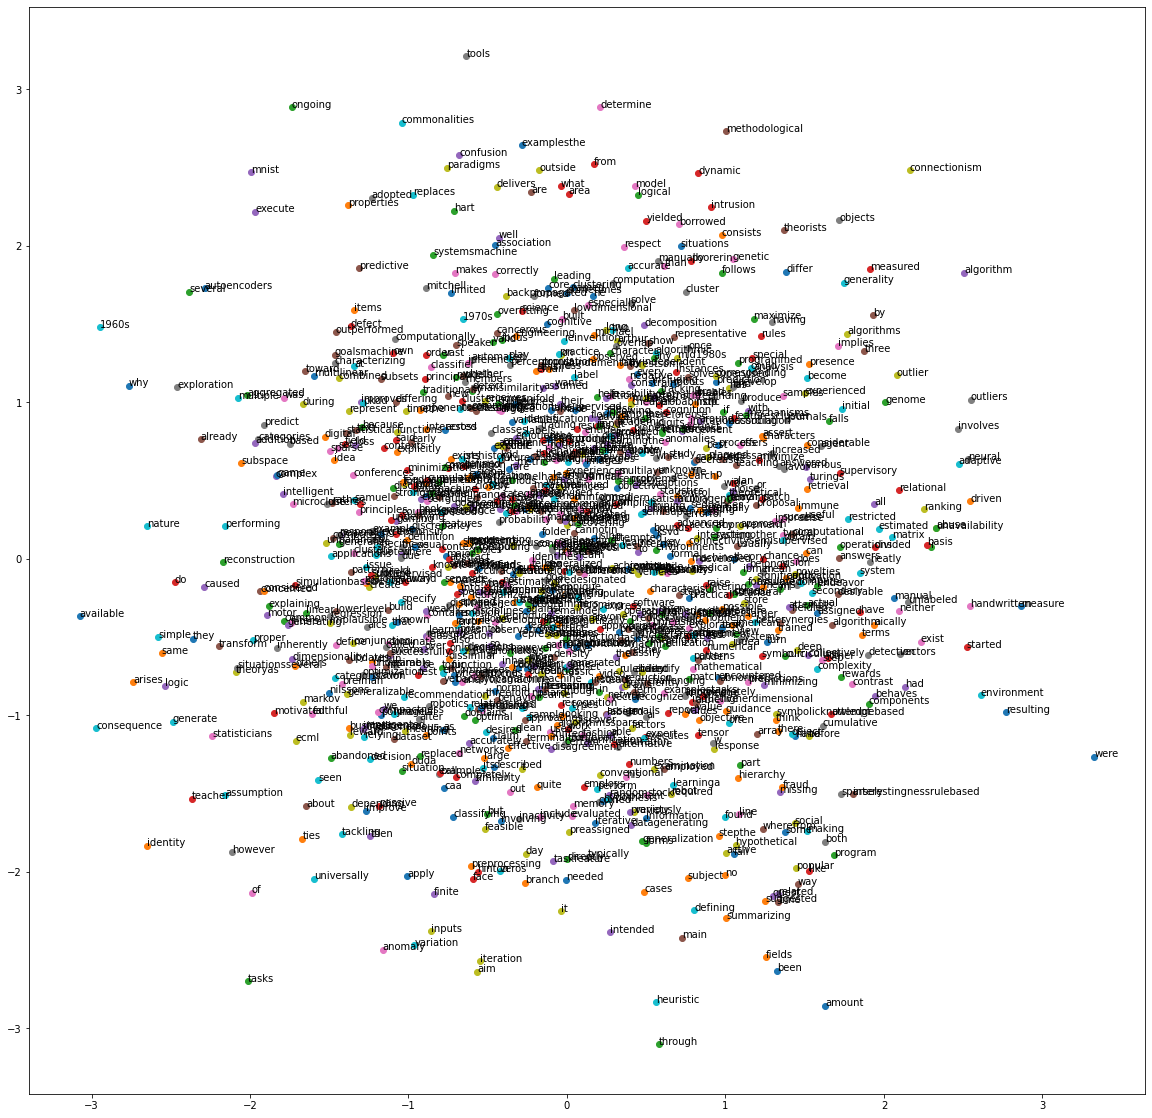

In [27]:
plt.figure(figsize = (20, 20))
for word, vector in word_to_reduce_vector.items():
  plt.scatter(vector[0], vector[1])
  plt.annotate(word, (vector[0], vector[1]))
plt.show() 